In [13]:
#Solana's notebook

!pip install --upgrade gensim

import pandas as pd
import numpy as np
import re, random, nltk, os
from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

You should consider upgrading via the 'C:\Users\rafmarin\PycharmProjects\FHC_MLE_Flavor\venv\Scripts\python.exe -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rafmarin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafmarin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Each row is a unique product. There are two columns, a de-identified company ID number and a flavor field. The flavor field may have multiple values in it that are comma separated (at first glance) so you may have to normalize it. Needs some scrubbing. We want to try to do a basic descriptive analysis first. See what is there. No one has ever looked. Number of uniques? Any common ones (value_counts)? Then we can think about embedding them and doing some clustering.

In [14]:
# Solana's path
# df = pd.read_csv(r'C:\Users\Solliu\Documents\Deloitte\Projects\FHC\FlavorData.csv')

df = pd.read_csv('FlavorData.csv')

In [15]:
df

,Company_ID,Characterizing_Flavor
0,0,Banana Menthol
1,0,Banana Menthol
2,0,Banana Menthol
3,0,Banana Menthol
4,0,Banana Menthol
...,...,...
1048570,150,Port Royale
1048571,150,Mardi Gras
1048572,150,Mardi Gras
1048573,150,Mardi Gras


In [16]:
#check out the unique values for characterizing flavor. It seems like there are over 10,000 unique values for flavors.
print(df['Characterizing_Flavor'].unique())
print(df.Characterizing_Flavor.nunique())

['Banana Menthol' 'Blue Raspberry' 'Vanilla Blue Raspberry' ...
 'Wild Cut E-liquid' 'Port Royale' 'Mardi Gras']
5130


In [17]:
#Let's look at the top 10 most common flavors
df['Characterizing_Flavor'].value_counts().head(20)

Spearmint            1839
Caramel Candy        1598
Sweet Cream          1560
Extreme Ice          1505
Chocolate Mint       1420
Cotton Candy         1317
Cinnamon             1272
Butter Cream         1272
Blueberry            1267
Sweetener            1208
Sour                 1194
Cucumber Mint        1194
Cinnamon Red Hot     1171
Pie Crust            1170
Butter Rum           1170
Strawberry Banana    1149
Pear                 1131
Candy Cane           1123
Orange               1105
Pumpkin Spice        1104
Name: Characterizing_Flavor, dtype: int64

In [18]:
#Let's work on cleaning up the data. We see here a bunch of null values..
df[df['Characterizing_Flavor'].isnull()]

,Company_ID,Characterizing_Flavor


Let's clean up the data by normalizing case, replacing typos, and replacing miscellaeneous characters

In [19]:
df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.lower() #normalize case
df['Characterizing_Flavor'].fillna(value='Not Found', inplace= True) #sub null values
df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.strip() #remove trailing and leading spaces
df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace(r"(?<=\w)-(?=\w)", " ")  # Replace dash between words
df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace(',','')
df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace('|','')
df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace('-','')
df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace(':','')
df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace('®','')
df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace(r"\s+", " ") #remove multiple spaces
df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace(r'\s*\b[/mgl\d\s.]+$', '', regex=True) #removes trailing mg,numbers, characters


C:\Users\rafmarin\AppData\Local\Temp/ipykernel_6388/2478391564.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace(r"(?<=\w)-(?=\w)", " ")  # Replace dash between words
C:\Users\rafmarin\AppData\Local\Temp/ipykernel_6388/2478391564.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace('|','')
C:\Users\rafmarin\AppData\Local\Temp/ipykernel_6388/2478391564.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Characterizing_Flavor'] = df['Characterizing_Flavor'].str.replace(r"\s+", " ") #remove multiple spaces


In [20]:
replacements = {'mentho':'menthol','cocunut':'coconut','lycehee':'lychee','starwberry':'strawberry', 'srawberry':'strawberry',
                'strawberrry':'strawberry', 'stawberry':'strawberry','koconut':'coconut','rocksatar':'rockstar',
                'lrishcrea':'irish cream', 'icin':'icing', 'cockt':'cocktail','cocktai':'cocktail','coolmint':'cool mint',
                'vream':'cream', 'crea':'cream', 'mallow':'marshmallow','crakcer':'cracker', 'orangey':'orange',
                'whiteandbiue':'white and blue', 'watermelond':'watermelon','smoothi':'smoothie','coffe':'coffee',
                'cherryb1osso':'cherryblosso','caramel apples':'caramel apple','bllueberry':'blueberry',
                'banapanutbread':'banananutbread', 'strawberry and menthol':'strawberry menthol','menthol cotton candy':'cotton candy menthol',
                'grizzly apple coo':'grizzly apple','grape fruit':'grapefruit','cirque du salt berries 20mg/ml 2x':'cirque du salt berries',
                'cirque du salt berries 50mg/ml 2x':'cirque du salt berries', 'watermelon melon menthol':'watermelon menthol',
                'cinnamon roll (la) diy':'cinnamon roll (la)','cinnabunns':'cinnabun','alaska elixirs loaffetti formerly funfetti':'funfetti'
               }

def replace_all(text, dic):
    for i, j in dic.items():
        text = re.sub(r"\b%s\b" % i, j, text) # r"\b%s\b"% enables replacing by whole word matches only
    return text

df['Characterizing_Flavor'] = df['Characterizing_Flavor'].apply(lambda x: replace_all(x, replacements))

In [21]:
#It looks like it changed # uniques and top 10! Nice. Let's keep going.
print(df.Characterizing_Flavor.nunique())
df['Characterizing_Flavor'].value_counts().head(30)

4786


spearmint                2014
extreme ice              1855
pumpkin spice            1806
chocolate mint           1770
sweet cream              1735
blueberry                1617
caramel candy            1598
coffee                   1557
cucumber mint            1551
sweetener                1442
cotton candy             1317
pear                     1306
english toffee           1298
dutch apple pie          1298
cinnamon                 1272
butter cream             1272
milk chocolate           1267
watermelon               1248
raspberry                1227
strawberry               1216
sour                     1194
black cherry             1187
ruby red grapefruit      1182
cinnamon red hot         1171
butter rum               1170
pie crust                1170
strawberry banana        1165
razzleberry              1131
cinnamon sugar cookie    1130
cinnamon hot tamale      1130
Name: Characterizing_Flavor, dtype: int64

In [22]:
#Let's also look at the top 5 companies and their most popular flavor


In [23]:
#Taking a look at the least common flavors to see if theres anything else we need to scrub
df['Characterizing_Flavor'].value_counts(ascending=True).head(59)


strawberry lemon ice                    1
coconut mint                            1
lemon mint                              1
lychee ice                              1
melon dew splash                        1
minty grape                             1
peach mango paradise                    1
pineapple lemonade                      1
russian cream                           1
cherryb1ossom                           1
washington cherry                       1
purple cloud                            1
cali life                               1
blueberry blast                         1
citrus crush                            1
strawberry fields                       1
naz                                     1
frozen orange juice                     1
summertime swirl                        1
gum mint                                1
imperial mix                            1
pound cake                              1
denali delight                          1
blue cotton                       

In [24]:
df[df['Characterizing_Flavor'].astype(str).str.contains('slush', regex = True)]


,Company_ID,Characterizing_Flavor
6875,7,blue raspberry slushie
6918,7,blue raspberry slushie
7010,7,blue raspberry slushie
7012,7,blue raspberry slushie
7053,7,blue raspberry slushie
7069,7,blue raspberry slushie
7118,7,blue raspberry slushie
7121,7,blue raspberry slushie


Generate texts from tokens in a column using the tokenizer function, which tokenizes text as well as removes stopwords


In [25]:
def tokenize_text(text, tokenizer, stopwords):
    tokens = tokenizer(text) # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = [t.replace("'s","") for t in tokens] # remove 's
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

In [26]:
#generate tokens from text in tokens column

custom_stopwords = set(stopwords.words("english"))
text_columns = ["Characterizing_Flavor"]

df_emb = df.copy()
df_emb.insert(2,"tokens",0)

#convert to string
for col in text_columns:
    df_emb[col] = df_emb[col].astype(str)

# tokenize text
df_emb["tokens"] = df_emb["Characterizing_Flavor"].map(lambda x: tokenize_text(x, word_tokenize, custom_stopwords))
print(df_emb)

# Remove duplicated after preprocessing
df_emb_uniq = df_emb.copy()
_, idx = np.unique(df_emb_uniq["tokens"], return_index=True)
df_emb_uniq = df_emb_uniq.iloc[idx, :]

# Remove empty values and keep relevant columns
df_emb = df_emb.loc[df_emb.tokens.map(lambda x: len(x) > 0), ["Characterizing_Flavor","tokens", 'Company_ID']]
df_emb_uniq = df_emb_uniq.loc[df_emb_uniq.tokens.map(lambda x: len(x) > 0), ["Characterizing_Flavor","tokens", 'Company_ID']]


print(f"Original dataframe: {df.shape}")
print(f"Pre-processed dataframe, w duplicates: {df_emb.shape}")
print(f"Pre-processed dataframe, without duplicates: {df_emb_uniq.shape}")




         Company_ID Characterizing_Flavor             tokens
0                 0        banana menthol  [banana, menthol]
1                 0        banana menthol  [banana, menthol]
2                 0        banana menthol  [banana, menthol]
3                 0        banana menthol  [banana, menthol]
4                 0        banana menthol  [banana, menthol]
...             ...                   ...                ...
1048570         150           port royale     [port, royale]
1048571         150            mardi gras      [mardi, gras]
1048572         150            mardi gras      [mardi, gras]
1048573         150            mardi gras      [mardi, gras]
1048574         150            mardi gras      [mardi, gras]

[1048575 rows x 3 columns]
Original dataframe: (1048575, 2)
Pre-processed dataframe, w duplicates: (1046978, 3)
Pre-processed dataframe, without duplicates: (4739, 3)


In [27]:
print(df_emb_uniq)

        Characterizing_Flavor                 tokens  Company_ID
6885                    100's                  [100]           7
7182               1000 berry          [1000, berry]           8
3410                      18q                  [18q]           3
58345       1950s era tobacco  [1950s, era, tobacco]          27
114881               27 bears            [27, bears]          27
...                       ...                    ...         ...
124561                   yuxi                 [yuxi]          27
124391                  yuyan                [yuyan]          27
176245         zombie's blood        [zombie, blood]          27
1008182      zombie blood max   [zombie, blood, max]          36
41665           zuppla flavor       [zuppla, flavor]          27

[4739 rows x 3 columns]


Now we will train a Word2Vec model using the tokens we generated earlier. This will output an array of vectors or number values for each token

In [28]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [52]:
tokenized_docs = df_emb.tokens.tolist()
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=SEED)

vectorized_docs = vectorize(tokenized_docs, model=model)

## what do these represent? length of the list of documents, size of the generated vectors
len(vectorized_docs), len(vectorized_docs[0])

# (1046978, 100)

(1046978, 100)

In [ ]:
## Output from word2vec
vectorized_docs

In [30]:
tokenized_docs_uniq = df_emb_uniq.tokens.tolist()
model_uniq = Word2Vec(sentences=tokenized_docs_uniq, vector_size=100, workers=1, seed=SEED)
vectorized_docs_uniq = vectorize(tokenized_docs_uniq, model=model_uniq)
len(vectorized_docs_uniq), len(vectorized_docs_uniq[0])

(4739, 100)

In [53]:
tokenized_docs_uniq

[['100'],
 ['1000', 'berry'],
 ['18q'],
 ['1950s', 'era', 'tobacco'],
 ['27', 'bears'],
 ['27', 'fish'],
 ['555', 'max'],
 ['6th', 'street'],
 ['absinthe'],
 ['absinthe', 'candy', 'flavor'],
 ['absinthe', 'flavor'],
 ['absinthe', 'flavor', 'concentrate'],
 ['absinthe', 'ii', 'flavor'],
 ['absolute', 'vapor', 'cloud', 'series', 'arcus', 'pulvia'],
 ['absolute', 'vapor', 'cloud', 'series', 'blustery', 'blizzard'],
 ['absolute', 'vapor', 'cloud', 'series', 'cumulus'],
 ['absolute', 'vapor', 'cloud', 'series', 'lenticular', 'v2'],
 ['absolute', 'vapor', 'cloud', 'series', 'mammatus'],
 ['absolute', 'vapor', 'cloud', 'series', 'storm'],
 ['absolute', 'vapor', 'infamous', 'series', 'btk'],
 ['absolute', 'vapor', 'infamous', 'series', 'dorcas', 'darkey', 'kelly'],
 ['absolute', 'vapor', 'infamous', 'series', 'jack', 'ripper'],
 ['absolute', 'vapor', 'personality', 'series', 'baby', 'bear'],
 ['absolute', 'vapor', 'personality', 'series', 'mama', 'bear'],
 ['absolute', 'vapor', 'personality', 

How many of the tokenized words are making it into the trained model?

In [31]:
#check # words in the resulting tokenized words.
flat_list = [item for sublist in tokenized_docs for item in sublist] #turn array of arrays into 1 array
print(len(flat_list))
unique_list = []
[unique_list.append(x) for x in flat_list if x not in unique_list] #remove duplicates
print("num unique words: ", len(unique_list))


3147606
num unique words:  2085


In [55]:
model.wv.key_to_index["guava"]


98

In [33]:
model.wv.key_to_index["strawberry"]

10

In [34]:
#get a list of vocab for the trained model
#why are we getting less words for trained model?
trained = []
for item in model.wv.index_to_key:
    trained.append(item)

print("num of words in trained model: ", len(trained))

unique_trained = []

[unique_trained.append(x) for x in trained if x not in unique_trained] #remove duplicates
print("num unique words: ", len(unique_trained))

num of words in trained model:  1969
num unique words:  1969


In [35]:
model.wv.similarity('banana', 'menthol')

-0.046972156

In [36]:
model.wv.most_similar("fruit")

[('dragon', 0.5292738080024719),
 ('limeade', 0.5084020495414734),
 ('mango', 0.4577297568321228),
 ('venom', 0.450908362865448),
 ('cucumber', 0.4469607174396515),
 ('pink', 0.44365304708480835),
 ('kiwi', 0.4163067042827606),
 ('natural', 0.41294288635253906),
 ('tobbaco', 0.40092602372169495),
 ('guava', 0.3975283205509186)]

Implement PCA to look at the variance of the data

In [37]:
np.shape(vectorized_docs) #9390 examples with 100 variables for each example


(1046978, 100)

In [94]:
def PCA(X , num_components):
    #center the data by subtracting the mean
    X_meaned = X - np.mean(X , axis = 0)

    # calculating the covariance matrix of the mean-centered data.
    cov_mat = np.cov(X_meaned , rowvar = False)

    #Calculating Eigenvalues and Eigenvectors of the covariance matrix. A higher Eigenvalue corresponds to a higher variability.
    #each column in the Eigen vector-matrix corresponds to a principal component
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

    #sort the eigenvalues in descending order. arranging them in descending order of their Eigenvalue will automatically
    #arrange the principal component in descending order of their variability.Hence the first column in our rearranged
    #Eigen vector-matrix will be a principal component that captures the highest variability
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]#similarly sort the eigenvectors

    #take top values depending on # components
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]

    #reduces dimension from 9390, 100 to 9390, 2
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()

    # determine explained variance
    total_eigen_values = sum(eigen_values)
    var_exp = [(i/total_eigen_values) for i in sorted(eigen_values, reverse=True)]

    # Plot the explained variance against cumulative explained variance
    cum_sum_exp = np.cumsum(var_exp)
    plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    return X_reduced, eigen_values

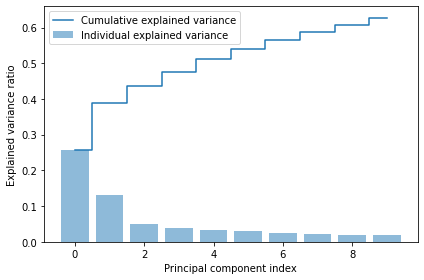

In [127]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Standardize the dataset
scaler = StandardScaler()
X_Scale = scaler.fit(vectorized_docs)

# apply PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(vectorized_docs)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

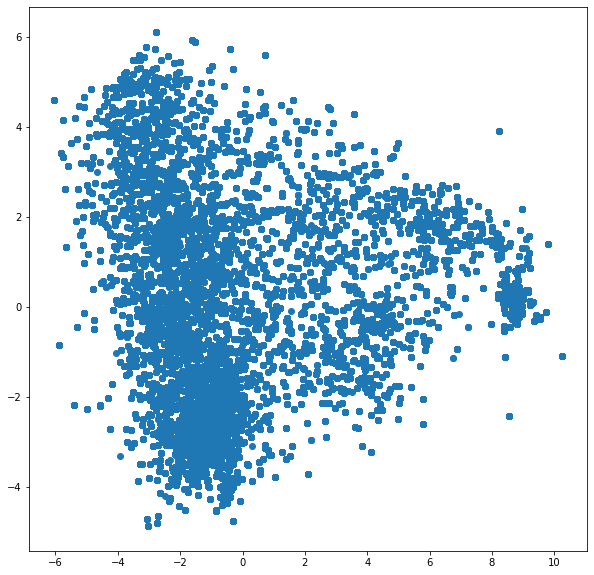

In [119]:
# create data frame
pc_df = pd.DataFrame(principalComponents  , columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',])
pc_df= pc_df.dropna(axis=0, how='any', inplace=False)
x_pc = pc_df.PC1.tolist()
y_pc = pc_df.PC2.tolist()
plt.figure(figsize=(10,10))
plt.scatter(x_pc, y_pc)

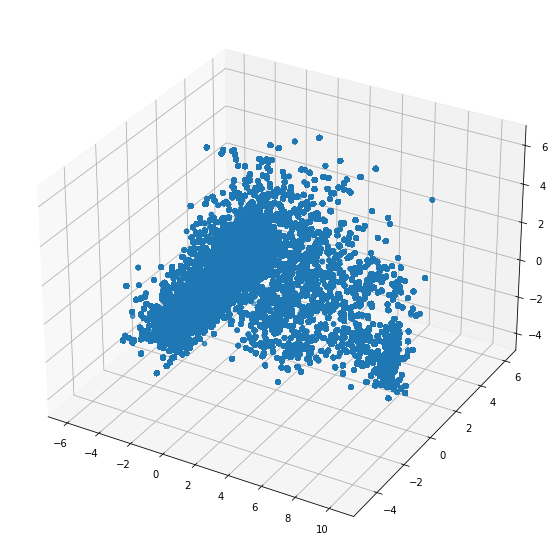

In [128]:
# PCA 3D
z_pc = pc_df.PC3.tolist()
fig3D = plt.figure(figsize=(10,10))
ax = fig3D.add_subplot(projection='3d')
ax.scatter(x_pc,y_pc,z_pc)
plt.show()


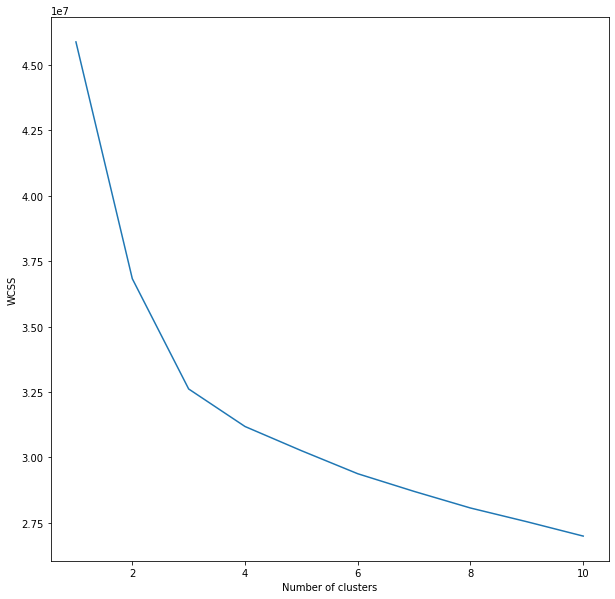

In [113]:
# Elbow Method
wcss = []
for i in range(1,11):
   model = KMeans(n_clusters = i, init = "k-means++")
   model.fit(vectorized_docs)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

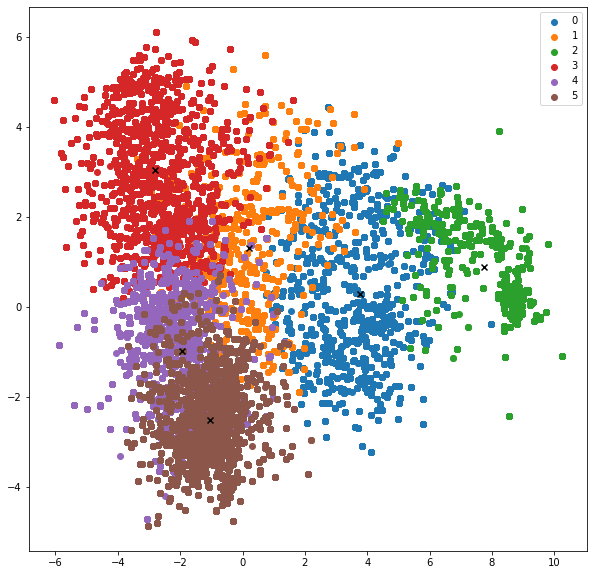

In [118]:
# K-Means
model = KMeans(n_clusters = 6, init = "k-means++")
label = model.fit_predict(principalComponents)
centers = np.array(model.cluster_centers_)
plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(principalComponents[label == i , 0] , principalComponents[label == i , 1] , label = i)


plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()
plt.show()

In [137]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = vectorized_docs.index.values
cluster_map['cluster'] = model.labels_


AttributeError: 'builtin_function_or_method' object has no attribute 'values'

In [155]:
pc_df.shape

#Concat it with target variable to create a complete Dataset
pc_df = pd.concat([pc_df , df_emb['Characterizing_Flavor']] , axis = 1)
pc_df = pd.concat([pc_df , df_emb['Company_ID']] , axis = 1)
pc_df = pd.concat([pc_df, principalComponents[label]], axis = 1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [153]:
principalComponents[label].shape

(1046978, 10)

In [ ]:
#Concat it with target variable to create a complete Dataset
principal_df = pd.concat([principal_df , df_emb['Characterizing_Flavor']] , axis = 1)
principal_df = pd.concat([principal_df , df_emb['Company_ID']] , axis = 1)
principal_df=principal_df.dropna(axis=0, how='any', inplace=False)

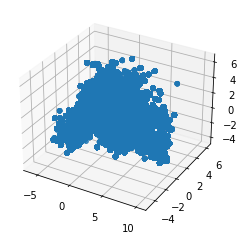

In [126]:
# K-Means 3D
plt.figure()
sx = plt.axes(projection = '3d')
sx.scatter(x_pc,y_pc,z_pc)

In [ ]:
mat_reduced = PCA(vectorized_docs , 2)

#Creating a Pandas DataFrame of reduced Dataset
principal_df = pd.DataFrame(mat_reduced , columns = ['PC1','PC2'])

#Concat it with target variable to create a complete Dataset
principal_df = pd.concat([principal_df , df_emb['Characterizing_Flavor']] , axis = 1)
principal_df = pd.concat([principal_df , df_emb['Company_ID']] , axis = 1)
principal_df=principal_df.dropna(axis=0, how='any', inplace=False)

# principal_df
print(principal_df.shape)

In [72]:
x=principal_df.PC1.tolist()
y=principal_df.PC2.tolist()

x

[2.125524795549551,
 2.125524795549551,
 2.125524795549551,
 2.125524795549551,
 2.125524795549551,
 2.125524795549551,
 2.125524795549551,
 2.125524795549551,
 2.125524795549551,
 3.9239896333791324,
 3.9239896333791324,
 3.9239896333791324,
 3.9239896333791324,
 3.9239896333791324,
 3.9239896333791324,
 3.9239896333791324,
 3.9239896333791324,
 3.9239896333791324,
 -0.14673634542513245,
 -0.14673634542513245,
 -0.14673634542513245,
 -0.14673634542513245,
 -0.14673634542513245,
 -0.14673634542513245,
 -0.14673634542513245,
 -0.14673634542513245,
 -0.14673634542513245,
 4.157499623849284,
 4.157499623849284,
 4.157499623849284,
 4.157499623849284,
 4.157499623849284,
 4.157499623849284,
 4.157499623849284,
 4.157499623849284,
 4.157499623849284,
 0.9654679291829297,
 0.9654679291829297,
 0.9654679291829297,
 0.9654679291829297,
 0.9654679291829297,
 0.9654679291829297,
 0.9654679291829297,
 0.9654679291829297,
 0.9654679291829297,
 5.505381997961927,
 5.505381997961927,
 5.505381997961

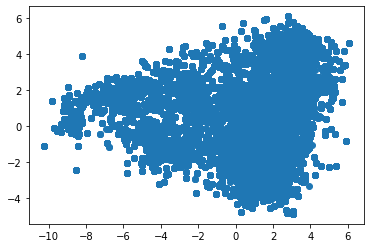

In [75]:
import matplotlib.pyplot as plt

plt.scatter(x, y)

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

#log the y values so it fits
mask = ~np.isinf(np.log(y)) # get mask of non-inf values


fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(np.array(x)[mask], np.log(y)[mask]) # plot only non-inf values

#plt.figure(figsize = (6,6))
#sb.scatterplot(data = principal_df , x = 'PC1'[mask], y = np.log('PC2')[mask] , hue = 'Characterizing_Flavor' , s = 60 , palette= 'icefire')




Here we're representing the data using PCA to reduce dimensionality. After determining the optimal # of clusters using the elbow method, we show the clusters here.

C:\Users\rafmarin\AppData\Local\Temp/ipykernel_6388/637254394.py:9: RuntimeWarning: invalid value encountered in log
  plt.scatter(np.array(x)[mask], np.log(y)[mask], c=labels)


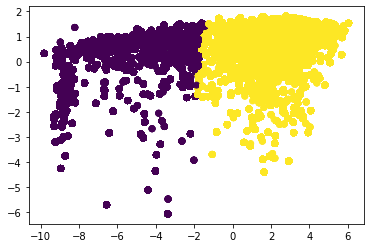

In [77]:
#https://andrewmourcos.github.io/blog/2019/06/06/PCA.html

from sklearn.cluster import KMeans

model_graph = KMeans(n_clusters=2) #Set number of clusters to desired clusters + 1
model_graph.fit(principal_df.iloc[:,:2])

labels = model_graph.predict(principal_df.iloc[:,:2])
plt.scatter(np.array(x)[mask], np.log(y)[mask], c=labels)
plt.show()

Okay, let's look at what is in these clusters next and where the top 10 flavor selling companies are in these clusters.

In [43]:
#counts number of flavors sold by company. #checked.
top_selling_comp = principal_df.groupby('Company_ID')['Characterizing_Flavor'].count().sort_values(ascending=False).head(5).index.tolist()
top_selling_comp

[27.0, 36.0, 29.0, 6.0, 13.0]

In [44]:
#get df points for top companies
top_companies = principal_df[principal_df['Company_ID'].isin(top_selling_comp)]
top_companies

,PC1,PC2,Characterizing_Flavor,Company_ID
3799,-5.155302,0.659414,almond,6.0
3800,-5.155302,0.659414,almond,6.0
3801,0.867711,-0.054517,apple moonshine,6.0
3802,1.118679,-1.596456,fire & ice,6.0
3803,1.118679,-1.596456,fire & ice,6.0
...,...,...,...,...
1045850,2.328397,1.044957,birthday cake,36.0
1045851,1.659039,0.347238,french vanilla,36.0
1045852,0.964268,-1.337940,espresso,36.0
1045853,1.659039,0.347238,french vanilla,36.0


C:\Users\rafmarin\AppData\Local\Temp/ipykernel_6388/2742529652.py:5: RuntimeWarning: invalid value encountered in log
  ax.scatter(np.array(x)[mask], np.log(y)[mask]) # plot only non-inf values
C:\Users\rafmarin\AppData\Local\Temp/ipykernel_6388/2742529652.py:7: RuntimeWarning: invalid value encountered in log
  mask1 = ~np.isinf(np.log(y1)) # get mask of non-inf values
C:\Users\rafmarin\AppData\Local\Temp/ipykernel_6388/2742529652.py:8: RuntimeWarning: invalid value encountered in log
  ax.scatter(np.array(x1)[mask1], np.log(y1)[mask1], c='lightblue')


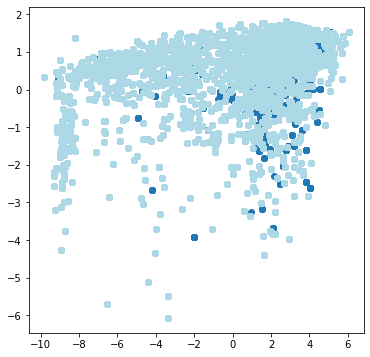

In [45]:
x1=top_companies.PC1.tolist()
y1=top_companies.PC2.tolist()

fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(np.array(x)[mask], np.log(y)[mask]) # plot only non-inf values

mask1 = ~np.isinf(np.log(y1)) # get mask of non-inf values
ax.scatter(np.array(x1)[mask1], np.log(y1)[mask1], c='lightblue')


In [46]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);

    return kmeans_clustering.cluster_centers_, idx;

In [47]:
model.wv?

In [48]:
centers, clusters = clustering_on_wordvecs(vectorized_docs, 5);
centroid_map = dict(zip(model.wv.index_to_key, clusters))

In [49]:
from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;

def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);
#Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    #print('closest points...', len(closest_points))
    #print(closest_points)

    closest_words_idxs = [x[1] for x in closest_points];
    #print('closest_words_idxs...', len(closest_words_idxs))
    #print(closest_words_idxs)
#Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i)] = [index2word[j] for j in closest_words_idxs[i][0]]
        #print('i...', i)
        #print("str(i)...", str(i))
        #print("index2word[j]...", index2word[j])
        #print('j...',j)
        #print('closest_words_idxs[i][0]...', closest_words_idxs[i][0])
        #print(closest_words)


    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1
    return df;

In [50]:
closest_words_idxs[0][0]

NameError: name 'closest_words_idxs' is not defined

In [ ]:
vectorized_docs

In [ ]:
tree = KDTree(vectorized_docs)
closest_points = [tree.query(np.reshape(x, (1, -1)), k=5) for x in centers]

In [ ]:
closest_words_idxs = [x[1] for x in closest_points];
len(closest_words_idxs)

In [ ]:
closest_points

In [ ]:
closest_words_idxs

In [ ]:
model.wv.index_to_key[0]

In [ ]:
model.wv.most_similar(positive=0)

In [ ]:
top_words = get_top_words(model.wv.index_to_key, 5, centers, vectorized_docs);


APPENDIX

To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion and is not rapidly changing anymore. Based on these graphs, the **optimal K value looks to be 5 (inertia) or 7 (distortion)**

In [ ]:
#Building the clustering model and calculating the values of the Distortion and Inertia
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 40)
X = np.array(list(zip(vectorized_docs[0],vectorized_docs[1]))).reshape(len(vectorized_docs[0]), 2) #what does this X mean?
os.environ["OMP_NUM_THREADS"] = "1"

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

In [ ]:
#Using the different values of Distortion
#for key, val in mapping1.items():
#	print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
#for key, val in mapping2.items():
#    print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
## calculating optimal value of k using elbow method
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import os



In [ ]:
# Visualizing the data
plt.plot()
plt.xlim([0, 3])
plt.ylim([0, 3])
plt.title('Dataset')
plt.scatter(vectorized_docs[0],vectorized_docs[1])
plt.show()


In [ ]:
def mbkmeans_clusters(
	X,
    k,
    mb,
    print_silhouette_values,
):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [ ]:
##this is using the non duplicated

#higher sil. coef is denser clusters
#k is # clusters. look into intracluster distance(avg distance of all the points from the center), graph & elbow point
#mini k vs k

os.environ["OMP_NUM_THREADS"] = "2"

clustering, cluster_labels = mbkmeans_clusters(
	X=vectorized_docs,
    k=4,
    mb=500,
    print_silhouette_values=True,
)
df_clusters = pd.DataFrame({
    "text": vectorized_docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

In [ ]:
print("Most representative terms per cluster (based on centroids):")
for i in range(4):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=10)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

When k=5, Clusters 1 & 4 have almost exact top 10 representative words. 4 clusters seems to be the best in this case

In [ ]:

#to do
#clean data more
#embedding failures. how much of the vocab is being represented?
--not all words are in word2vec. are there words that are not being represented in there?
--compare our vocab vs word2vec vocab. how much % of vocab is being represented in that vocab?

#plot the clusters, pca to check variance of clusters, want to keep 70-80% of data, t-sne
--pca: dimensionality reduction (e.g. groups columns into principal components)
--chunking flavors that are mixed together
--check dimensionality reduction is adequate
--use 2 or 3 of vectors representing each number (right now there are 100 per word)
--pca also used to determine how many cluster for k means

#plot the clusters, coloring in by company ID

#less important but also to do
#k means vs mini k means

In [ ]:
df_emb[df_emb['Characterizing_Flavor'].astype(str).str.contains('banana', regex = True)]

In [ ]:
df[df['Characterizing_Flavor'].astype(str).str.contains('icin', regex = True)]

In [ ]:
df[df['Characterizing_Flavor'].astype(str).str.contains('zombie', regex = True)]